# Anticipez les besoins en consommation électrique de bâtiments

- **Projet 4 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 1 : Nettoyage et analyse exploratoire des données

<img width="200" src="https://user.oc-static.com/upload/2019/02/24/15510245026714_Seattle_logo_landscape_blue-black.png" alt="Logo seattle">


# 1. Compréhension du problème

## 1.1 Mission

À partir des [relevés déjà réalisés en 2015 et 2016](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv) :

- **prédire les émissions de CO2** et la **consommation totale d’énergie** de bâtiments commerciales en Seattle pour lesquels elles n’ont pas encore été mesurées, basé sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction…).

- **évaluer l’intérêt de l’[ENERGY STAR Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what) pour la prédiction d’émissions**.


### 1.1.1 Quelles variables pour prédire les consommations / emissions CO2 ?

Il faut prédire les targets uniquement avec les données disponibles sur le permis d'exploitation commerciale :

- on ne peut pas utiliser les relevés de consommation d'électricité, de gaz, etc comme paramètres des prévisions.
- on peut utiliser type d'usage, surface, nombre d'étages, moyenne de chauffage, ...


### 1.1.2 Quels bâtiments à inclure dans les prévisions ?

Il faut prédire les targets uniquement pour les bâtiments commerciaux.

Donc, il faut éliminer les bâtiments residential, si possible.


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook

### 1.2.1 Import des bibliothèques


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### 1.2.2 Liste des versions des bibliothèques utilisées


In [2]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2


### 1.2.3 Configuration défauts d'affichage


In [3]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 10)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
# pd.set_option('display.precision', 2)

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**

"A_suptitle-_train___test.png"


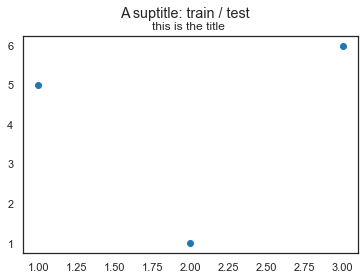

In [4]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


def to_png(fig_name=None):
    """
    Enregistre l'image dans un fichier,
    il faut appeler avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour être sûr d'inclure le titre / legend entier.
    """

    def get_title():
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(
            ':', '-').replace('.', '-').replace('/', '_')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')

plt.scatter(x=[1,2,3],y=[5,1,6])
plt.suptitle('A suptitle: train / test')
plt.title('this is the title ')
to_png()


# Import et nettoyage des données

# 2.1 Import des données

Les données de consommation sont à télécharger à [cette adresse](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv).


### 2.1.1 Les métadonnées

- les descriptions des champs sont fournies par les fichiers metadata (format json)
- conversion en CSV pour faciliter la lecture


In [5]:
import os
import json


def create_data_dict_csv_from_json(file: str, outfile: str) -> pd.DataFrame:
    if os.path.exists(outfile):
        return pd.read_csv(outfile).iloc[:, -3:]
    data = json.loads(open(file, "r").read())
    df = pd.json_normalize([data], record_path='columns', max_level=0)
    df = df[['name', 'dataTypeName', 'description']]
    df.to_csv(outfile)
    return df


meta2015 = 'data/raw/socrata_metadata_2015-building-energy-benchmarking.json'
meta2016 = 'data/raw/socrata_metadata_2016-building-energy-benchmarking.json'

if not os.path.exists('data/out'):
    os.makedirs('data/out')
out2015 = 'data/out/datadict2015.csv'
out2016 = 'data/out/datadict2016.csv'

dict2015 = create_data_dict_csv_from_json(meta2015, out2015)
dict2016 = create_data_dict_csv_from_json(meta2016, out2016)
print(f'2015 : il y a {len(dict2015)} colonnes')
print(f'2016 : il y a {len(dict2016)} colonnes')


2015 : il y a 47 colonnes
2016 : il y a 46 colonnes


## Les target (labels) à prédire

En regardent les descriptions des champs (les fichiers CSV), on voit que les champs à prédire sont :

- `SiteEnergyUse(kBtu)` = **consommation totale d’énergie**
- `TotalGHGEmissions` = **les émissions de CO2 (equivalence)**

Il y aussi le champ `ENERGYSTARScore` à évaluer pour la prédiction


In [6]:
dict2016[dict2016['name'].isin(
    ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore'])]


,name,dataTypeName,description
28,ENERGYSTARScore,text,"An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median."
33,SiteEnergyUse(kBtu),number,The annual amount of energy consumed by the property from all sources of energy.
44,TotalGHGEmissions,text,"The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu."


### Est-ce que les données de 2015 et 2016 sont compatibles ?


In [7]:
cols_unique2015 = set(list(dict2015['name'])) - set(list(dict2016['name']))
cols_unique2016 = set(list(dict2016['name'])) - set(list(dict2015['name']))
print(f'colonnes unique à année 2015 : {sorted(cols_unique2015)}')
print(f'colonnes unique à année 2016 : {sorted(cols_unique2016)}')


colonnes unique à année 2015 : ['2010 Census Tracts', 'City Council Districts', 'Comment', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Location', 'OtherFuelUse(kBtu)', 'SPD Beats', 'Seattle Police Department Micro Community Policing Plan Areas', 'Zip Codes']
colonnes unique à année 2016 : ['Address', 'City', 'Comments', 'GHGEmissionsIntensity', 'Latitude', 'Longitude', 'State', 'TotalGHGEmissions', 'ZipCode']
